Script Description:
-------------------
This script is developed for doing simple heritability estimation testing using SLMM. 
It involves the use of genotype and phenotype files created through specific settings 
and simulations. The script includes classes and methods for estimating heritability 
and visualizing the results.


Files Required:
---------------
- Genotype files: test.bed, test.fam, test.bim. The number of SNPs is set to 25000 with 20000 samples.
- Phenotype files: single.h2.0.10.10000.phen with heritability of 0.1.


In [27]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from slmm.kernel import LinearKernel, NoiseKernel
from slmm._model_ai import AverageInformation as LMM
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setting plot parameters for aesthetics
plt.rcParams["axes.linewidth"] = 2.0 

In [30]:
# Defining parameters for heritability estimations
snps = 25000  # Number of SNPs included in the kernel for estimation
sample_size = 20000 # Size of the sample used for estimation

In [56]:
class H2_estimation:
    """
    A class to estimate heritability using SLMM.

    Attributes:
    -----------
    SEED : int
        A seed value for random number generation.
    snps : int
        The number of SNPs to be included in the analysis.
    H2_1 : float
        The simulated heritability value.
    result_path : str
        Path to store results.
    GENOTYPE_N_SAMPLES : int
        Number of genotype samples.
    GENOTYPE_FILENAME : str
        Path to the genotype file.
    y : array
        Phenotype values.
    M : array
        Covariate matrix.

    Methods:
    --------
    define_kernels():
        Defines the kernels required for SLMM.
    fit():
        Fits the LMM model to the data.
    """

    def __init__(self, SIM_NO, simulated_sample, snps, H2):
        phenotype_path = "./phenotype"
        self.SEED = 1234
        self.snps = snps
        self.H2_1 = H2
        self.result_path = "."
        self.GENOTYPE_N_SAMPLES = simulated_sample
        self.GENOTYPE_FILENAME = "./genotype"
        self.sample_size = sample_size

        # Loading phenotypes and covariates
        file = pd.read_csv(f'{phenotype_path}/single.h2.{self.H2_1:.2f}.snps{self.snps}.sample{self.sample_size}.phen', header=None, sep=' ')
        phenotype = file.iloc[:, 2+SIM_NO].values
        self.y = phenotype
        self.M = np.ones((self.sample_size, 1))
        self.SIM_NO = SIM_NO

    def define_kernels(self):
        # Defining and loading genotype and noise kernels
        K_q = LinearKernel(file_name=f"{self.GENOTYPE_FILENAME}/test_snps{self.snps}_sample{self.GENOTYPE_N_SAMPLES}", 
                           file_type="bed", 
                           n_sample=self.GENOTYPE_N_SAMPLES, 
                           name="test_snps", 
                           n_features=self.snps, 
                           n_thread=20, 
                           load=True,
                           in_core=True,
                           sample_indices=np.linspace(0,sample_size-1,sample_size).astype(np.uint32)
                           )
        
        I = NoiseKernel(self.sample_size)
        self.V = K_q + I

        # Defining the LMM model
        self.LMM = LMM(kernels=self.V, y=self.y, X=self.M, seed=self.SEED,
                       id=f"h2.{self.H2_1}.sample_size.{self.sample_size}.{self.SIM_NO}", 
                       n_thread=40, solver_max_iter=500, n_probe_start=41, pretrain=False, 
                       optimizer_convergence_tol_start=1.0, optimizer_convergence_tol_final=1e-6,
                       path=self.result_path, perform_final_step=False)

    def fit(self):
        # Fitting the LMM model and then save it
        self.define_kernels()
        self.LMM.fit()
        self.LMM.save()

In [57]:
# Simulation parameters
start = 0
end = 2 # Fitting 2 replicates of simulated data
num_simulations = 100
simulated_sample = 20000
all_sims = range(num_simulations)

# DataFrame to store sigma estimates
sigma_df = pd.DataFrame()
sigma_estimates_1 = dict()


# Looping through simulations with heritability 0.1
for sim_no in all_sims[start:end]:
    test_q = H2_estimation(SIM_NO=sim_no, simulated_sample=simulated_sample, snps=snps, H2=0.1)
    test_q.fit()
    sigma = test_q.LMM.parameters[0]
    sigma_estimates_1[sim_no] = sigma
    del test_q

sig = pd.DataFrame.from_dict(sigma_estimates_1, orient="index")
sigma_df[f"Simulated heritability:{0.1}"] = sig

Reading segments: 100%|##########| 2778/2778 [00:00<00:00, 2813.55it/s]
[COVAR] no weight no alpha
self.Z_first [[-1.  1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]]
self.Z_second [[-1.  1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1.  1.]
 [-1.  1.]]
Checking if file exist at: ./slmm.model.h2.0.1.sample_size.20000.0.result.slz
No recovery file found. Starting the process from scratch.
[Distributed] No slurm cluster detected, proceed as a single machine run.
Average Information (AI) training
	No. of parameters: 2
	Max no. of training iterations: 20
	Max no. of rejection per iterations: 5
	Convergence tol for difference in loglikelihoods (starting phase): 1.0
	Convergence tol for the solver (starting phase): 0.001
	No. of probes (starting phase): 41
	No. of probes (final phase): 25
Loading kernel/component no. 0
Loading kernel/component no. 1
All kernels/components are loaded.
Multiplying probes with the kernels/components
Adjusting kernel traces for fixed effect projection

FIRST STEP TRAINING -- ST

In [64]:
## load results from SLMM estimations
from slmm import util

sigma_df = pd.DataFrame()
sigma_estimates_1 = dict()

for i in range(end):
    file = util._load(f"./results/slmm.model.h2.0.1.sample_size.20000.{i}.result")
    summary = file['summary']
    weighted_sigma = summary['final_estimate'][0] * summary['kernel_weight'][0]
    sigma_estimates_1[i] = weighted_sigma

sig = pd.DataFrame.from_dict(sigma_estimates_1, orient="index")
sigma_df[f"Simulated heritability:{0.1}"] = sig

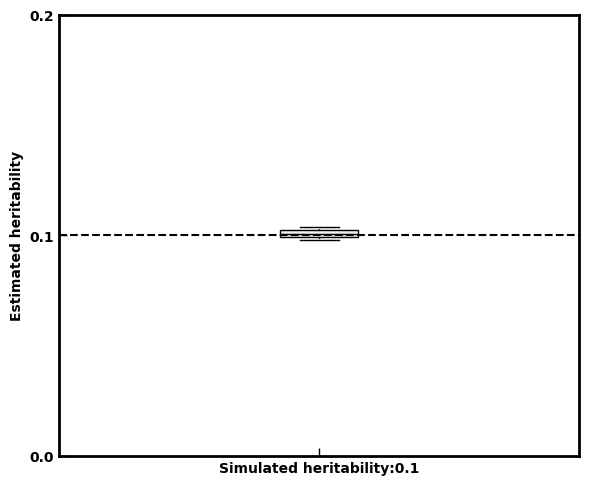

In [65]:
# Visualization of results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), sharey=True)
boxplot = axes.boxplot(sigma_df, patch_artist=True)

# Customizing boxplot components
for box in boxplot['boxes']:
    box.set_facecolor('#eeeeee')  # Setting the box color
    box.set_linestyle('-')  # Setting the line style for the boxes

for median in boxplot['medians']:
    median.set_color('black')  # Setting the median line color

for whisker in boxplot['whiskers']:
    whisker.set_linestyle(':')  # Setting the whisker line style

# Final plot adjustments
plt.tight_layout()
plt.ylim(0, 0.2)
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.tick_params(labelsize=10, length=6, width=1, axis='both', direction='in')
plt.ylabel("Estimated heritability", fontsize=10, fontweight='bold')
axes.set_xticklabels(['Simulated heritability:0.1'], fontsize=10, fontweight='bold')
for label in axes.get_yticklabels():
    label.set_fontweight('bold')

# Displaying the plot
plt.axhline(y=0.1, color='black', linestyle='--')
plt.show()
